In [15]:
import pandas as pd
import matplotlib.pyplot as plt
#import pypyodbc 
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib.font_manager import FontProperties

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,mean_squared_error


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import quandl
quandl.ApiConfig.api_key = 'ik6y9JyGpmnDBkJjiF2Y'

# get the table for daily stock prices and,
# filter the table for selected tickers, columns within a time range
# set paginate to True because Quandl limits tables API to 10,000 rows per call
data = quandl.get_table('WIKI/PRICES', ticker = ['GOOGL'], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2014-12-31', 'lte': '2018-3-21' }, 
                        paginate=True)
data = data.sort_values(by='date', ascending=True)
data.head()

,ticker,date,adj_close
None,,,
809,GOOGL,2014-12-31,530.66000
808,GOOGL,2015-01-02,529.55000
807,GOOGL,2015-01-05,519.46000
806,GOOGL,2015-01-06,506.64000
805,GOOGL,2015-01-07,505.15000


In [50]:
df = pd.concat([data['date'],data['adj_close']],axis = 1)
df = df.set_index('date')
df['diff'] = df['adj_close'].diff()
#df = df.dropna()
df = df.dropna()
df_n = df

df_n.head()

,adj_close,diff
date,,
2015-01-02,529.55000,-1.11000
2015-01-05,519.46000,-10.09000
2015-01-06,506.64000,-12.82000
2015-01-07,505.15000,-1.49000
2015-01-08,506.91000,1.76000


In [51]:
## model order selection 
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(df_n['diff'],max_ar=5,max_ma=5,ic=['aic', 'bic'])
model_order = order.aic_min_order
print(model_order)

(3, 4)


In [52]:
## stationary test 
##dfoutput_x[1]<0.05 if true stationary 
dftest_y = sm.tsa.adfuller(df_n['diff'],autolag='BIC')
dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
stationary = dfoutput_y[1]<0.05
print('dependent stationary : %s'%(stationary)) 

dependent stationary : True


In [53]:
pred_days = 15
import datetime as dt
import pyflux as pf
forecast = pd.DataFrame()
realPrice = pd.DataFrame()
trainnum = np.int(df_n.shape[0]-pred_days)
for i in range(pred_days ):
    traidata = df_n.iloc[0:trainnum+i,:]
    testdata = df_n.iloc[trainnum+i:trainnum+i+1,:]
    ## stationary test 
    ##dfoutput_x[1]<0.05 if true stationary 
    dftest_y = sm.tsa.adfuller(df_n['diff'],autolag='BIC')
    dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    stationary = dfoutput_y[1]<0.05
    print('dependent stationary : %s'%(stationary))   

    
    _ar = model_order[0]
    _ma = model_order[1]
    model = pf.ARIMA(data=traidata , ar=_ar, ma=_ma, target='diff')
    model.fit("MLE")
    temp= model.predict(int(len( testdata )))
    forecast = pd.concat([forecast,temp],axis = 0)
    #print(testdata.adj_close)
    realPrice = pd.concat([realPrice,testdata],axis = 0)

dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True
dependent stationary : True


In [54]:
##inverse price 
pred_price = np.r_[realPrice.iloc[0]['adj_close'], forecast['diff']].cumsum()
pred_price = pred_price[1:]
pred_price
#real_value = realPrice ['adj_close'].values

array([1072.8459 , 1069.21671, 1069.46039, 1071.43123, 1076.85281,
       1078.56172, 1080.2711 , 1082.76308, 1082.66508, 1080.37063,
       1079.09587, 1075.48697, 1074.60241, 1072.69068, 1071.03777])

In [55]:
len(pred_price)

15

In [68]:
##inverse price 
real_value = realPrice['adj_close'].values
real_value

array([1071.41, 1084.14, 1094.76, 1100.9 , 1115.04, 1129.38, 1160.84,
       1165.93, 1139.91, 1148.89, 1150.61, 1134.42, 1100.07, 1095.8 ,
       1094.  ])

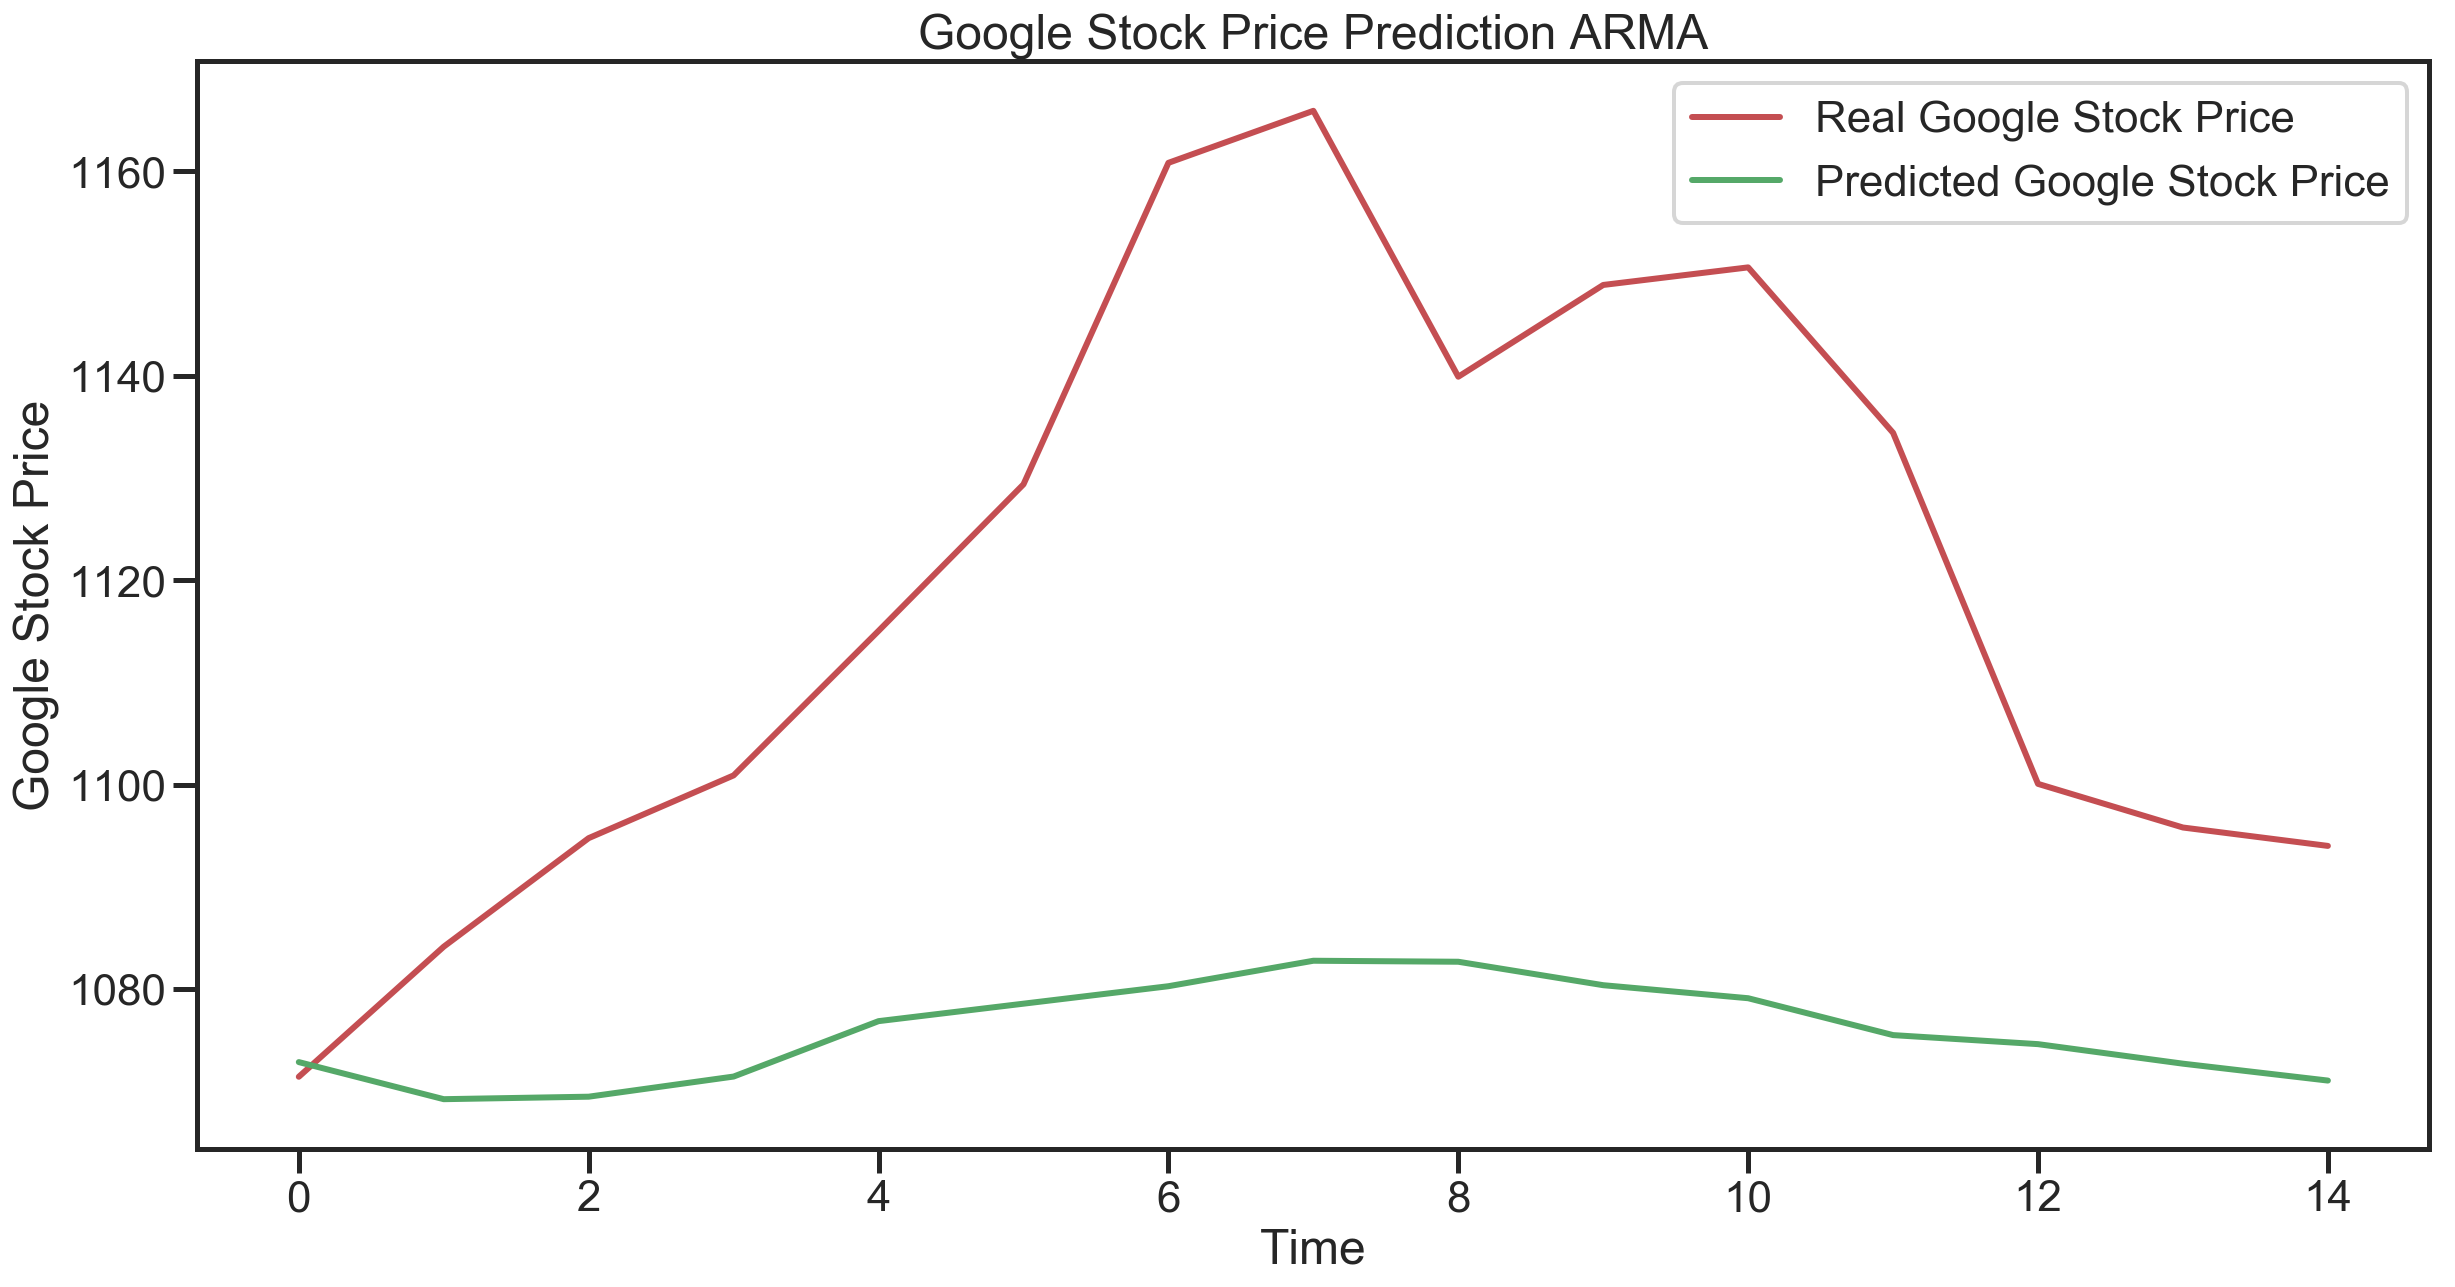

In [71]:
plt.figure(figsize=(20,10))
plt.plot(real_value,c = 'r',label = 'Real Google Stock Price')
plt.plot(pred_price,c = 'g', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction ARMA')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()